**Import Library**

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import os, sys
import pickle
from tqdm.notebook import tqdm

import warnings 
warnings.filterwarnings('ignore')

mpl.rc('font', family='New Gulim')
mpl.rc('axes', unicode_minus=False)

%matplotlib inline

**Import Data**

In [2]:
train_weather = pd.read_excel('./Data/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx')
train_weather = train_weather.rename(columns=train_weather.iloc[0])[1:].reset_index(drop=True)
train_weather = train_weather.loc[train_weather['상품군']!='무형'].reset_index(drop=True) # 상품군이 무형인 경우 예측하지 않음. 모두 0으로 처리 (*빅콘테스트 공지 참조)
train_weather['취급액'] = train_weather['취급액'].fillna(0)
train_weather = train_weather.loc[train_weather['취급액'] != 0].reset_index(drop = True) # 취급액 없음 변경

for i in tqdm(range(len(train_weather))):
    if pd.isna(train_weather.loc[i,'노출(분)']):
        train_weather.loc[i,'노출(분)'] = train_weather.loc[(i-1),'노출(분)']

train_weather['판매량'] = [round(train_weather.loc[i,'취급액']/train_weather.loc[i,'판매단가'] # 분당 판매량
                          /train_weather.loc[i,'노출(분)']) for i in range(len(train_weather))] 

In [3]:
# Train 데이터 날짜변수 생성
train_weather['date'] = train_weather['방송일시'].apply(lambda x:x.strftime('%Y-%m-%d'))
train_weather['hour'] = train_weather['방송일시'].apply(lambda x:x.strftime('%H'))
train_weather['weekday'] = train_weather['방송일시'].apply(lambda x:x.strftime('%w'))
train_weather['month'] = train_weather['방송일시'].apply(lambda x:x.strftime('%m'))
train_weather['day'] = train_weather['방송일시'].apply(lambda x:x.strftime('%d'))
train_weather['day'] = train_weather['day'].astype('int')

train_weather.head(3)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,date,hour,weekday,month,day
0,2019-01-01 06:00:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,3.0,2019-01-01,06,2,01,1
1,2019-01-01 06:00:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,5.0,2019-01-01,06,2,01,1
2,2019-01-01 06:20:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,4.0,2019-01-01,06,2,01,1


In [4]:
test_weather = pd.read_excel('./Data/2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx')
test_weather = test_weather.rename(columns=test_weather.iloc[0])[1:]
test_weather_mu = test_weather.loc[test_weather['상품군']=='무형'].reset_index() # 상품군이 무형인 경우 예측하지 않음. 모두 0으로 처리 (*빅콘테스트 공지 참조)
test_weather = test_weather.loc[test_weather['상품군']!='무형'].reset_index()

In [5]:
test_weather['date'] = test_weather['방송일시'].apply(lambda x:x.strftime('%Y-%m-%d'))
test_weather['hour'] = test_weather['방송일시'].apply(lambda x:x.strftime('%H'))
test_weather['weekday'] = test_weather['방송일시'].apply(lambda x:x.strftime('%w'))
test_weather['month'] = test_weather['방송일시'].apply(lambda x:x.strftime('%m'))
test_weather['day']=test_weather['방송일시'].apply(lambda x:x.strftime('%d'))
test_weather['day'] = test_weather['day'].astype('int')

## 기상변수

기상자료 개방 포털 데이터 활용

- 기온, 갈풍, 풍량, 호우, 폭염, 폭풍해일 기상 자료들을 수집

기상자료 개방 포털 데이터 활용하여 기상에 따른 홈쇼핑 판매량의 차이가 있는지 알아보자   

### 호우 주의보

In [6]:
# 2019년 호우 주의보 데이터
rain = pd.read_csv('./Weathers/FCT_WRN_호우.csv',encoding='cp949')
rain.head(3)

,특보통보,Unnamed: 1
0,발표시각,지역
1,2019-02-03 4:25,전국
2,발효시각,NaN


In [7]:
rain = rain.drop('Unnamed: 1',axis=1) # 호우주의보의 발표시각 및 발효시각만을 추출하여 이용
rain=rain.loc[rain['특보통보'].str.contains(pat='2019')==True].reset_index(drop=True) # 2019년도 데이터만 추출
rain=rain.loc[rain['특보통보'].str.contains(pat='호우주의보')==True].reset_index(drop=True) # 호우주의보 단어가 포함된 문장만 추출

rain.head(3) # 호우주의보 발표 및 해제 데이터 생성완료

,특보통보
0,(1) 호우주의보 발표 : 2019년 02월 03일 04시 25분
1,(1) 호우주의보 발표 : 2019년 02월 03일 05시 05분
2,(3) 호우주의보 해제 : 2019년 02월 03일 09시 00분


In [8]:
rain['구분'] = pd.Series() # 발표 및 해제를 의미
rain['year'] = pd.Series()
rain['month'] = pd.Series()
rain['day'] = pd.Series()
rain['hour'] = pd.Series()
rain['minute'] = pd.Series()
rain['date'] = pd.Series()

for i in tqdm(range(len(rain))):
    rain.loc[i,'구분']=rain.loc[i,'특보통보'][10:12]
    rain.loc[i,'year']=rain.loc[i,'특보통보'][15:19]
    rain.loc[i,'month']=rain.loc[i,'특보통보'][21:23]
    rain.loc[i,'day']=rain.loc[i,'특보통보'][25:27]
    rain.loc[i,'hour']=rain.loc[i,'특보통보'][29:31]
    rain.loc[i,'minute']=rain.loc[i,'특보통보'][33:35]

rain['date']=rain['year']+'-'+rain['month']+'-'+rain['day']+' '+rain['hour']+':'+rain['minute'] # 새로운 날짜 형식으로 변수 생성
rain=rain[rain['구분']!='변경'] # 발표 및 해제만 사용하기 위함
rain=rain.drop_duplicates() # 중복 값 제거
rain=rain.reset_index(drop=True) # 인덱스 조정

rain.head(3)

,특보통보,구분,year,month,day,hour,minute,date
0,(1) 호우주의보 발표 : 2019년 02월 03일 04시 25분,발표,2019,02,03,04,25,2019-02-03 04:25
1,(1) 호우주의보 발표 : 2019년 02월 03일 05시 05분,발표,2019,02,03,05,05,2019-02-03 05:05
2,(3) 호우주의보 해제 : 2019년 02월 03일 09시 00분,해제,2019,02,03,09,00,2019-02-03 09:00


In [9]:
raining_list = [0] # 발표와 해제가 순서대로 이루어진 인덱스로 이루어진 리스트

# 해제와 발표가 정상적으로 이루어진 경우의 인덱스를 추출하여 변수 생성
for i in tqdm(range(len(rain))):
    if i == (len(rain)-1):
        raining_list.append(i)
        break
    a = rain.loc[i,'구분']
    b = rain.loc[i+1,'구분']
    if (a == '해제')&(b=='발표'):
        raining_list.append(i)
        raining_list.append(i+1)
    
rain = rain.iloc[raining_list].reset_index(drop=True)
rain = rain.drop('특보통보',axis=1)
rain['date']=pd.to_datetime(rain['date'],format='%Y-%m-%d %H:%M:%S')

with open('./pickles/rain.pkl', 'wb') as f: # 완성된 데이터 셋 pickle 형태로 저장
    pickle.dump(rain, f)

rain.head(5) # 최종 호우주의보 데이터 셋 생성 완료

,구분,year,month,day,hour,minute,date
0,발표,2019,02,03,04,25,2019-02-03 04:25:00
1,해제,2019,02,03,09,00,2019-02-03 09:00:00
2,발표,2019,02,19,00,00,2019-02-19 00:00:00
3,해제,2019,02,19,09,00,2019-02-19 09:00:00
4,발표,2019,03,09,15,00,2019-03-09 15:00:00


In [10]:
# Train 데이터에 호우주의보 변수 생성
train_weather['rain']=0.0

for j in tqdm(range(len(rain))):
    if j%2==0:
        train_weather.loc[(train_weather['방송일시']>rain['date'][j]) & (train_weather['방송일시']<rain['date'][j+1]),'rain']=1.0

#### 막대 그래프를 통한 변수의 유의성 시각화

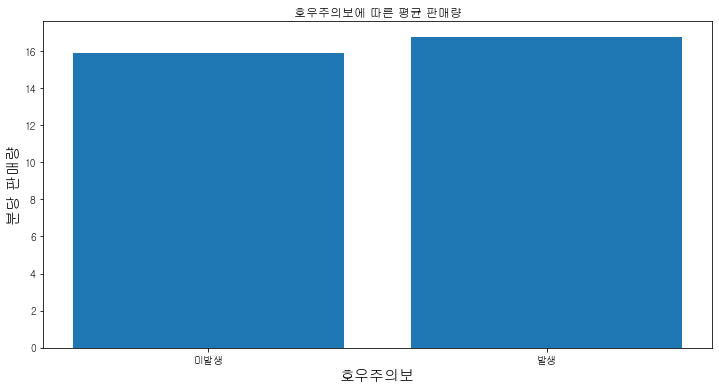

In [11]:
rain_group_df = train_weather['판매량'].groupby(train_weather['rain']).mean()

title = '호우주의보에 따른 평균 판매량'
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(list(rain_group_df.index), rain_group_df)
ax.set_xlabel('호우주의보', fontsize = 15)
ax.set_xticks([0, 1])
ax.set_xticklabels(['미발생', '발생'], fontsize = 10)
ax.set_ylabel('분당 판매량', fontsize = 15)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

#### T-Test

- H0 : 호우주의보 발생 여부에 따른 분당 평균 판매량은 차이가 없다.

- H1 : 호우주의보 발생 여부에 따른 분당 평균 판매량은 차이가 있다.

두 집단은 독립이므로 등분산 검정을 실시한 후 독립표본 t-검정을 시행한다.   

In [12]:
# 등분산 검정
# H0 : 두 집단의 분산은 같다.
# H1 : 두 집단은 분산은 다르다.
rain_0 = train_weather.loc[train_weather['rain'] == 0.0] # 호우주의보 미발령
rain_1 = train_weather.loc[train_weather['rain'] == 1.0] # 호우주의보 발령

# Levene의 등분산 검정 
lresult = stats.levene(rain_0['판매량'], rain_1['판매량'])
print('LeveneResult(F) : %.3f \np-value : %.3f' % (lresult)) 

LeveneResult(F) : 9.862 
p-value : 0.002


- p-value 0.002로 유의확률 0.05보다 작으므로 귀무가설을 기각한다.
- 즉, 두 집단의 분산은 다르다는 것을 알 수 있다.

In [13]:
# 등분산이 아닌 독립표본 t-검정 실행 
t_result = stats.ttest_ind(rain_0['판매량'], rain_1['판매량'], equal_var=False) 
print('t statistic : %.3f \np-value : %.3f' % (t_result))

t statistic : -2.146 
p-value : 0.032


두 집단 간 평균 판매량에 대한 T-test를 진행한 결과, p-value가 0.032로 유의확률 0.05보다 작으므로 귀무가설을 기각한다.   
즉, 호우주의보 발생 여부에 따른 분단 평균 판매량은 차이가 있다고 할 수 있다.   
'호우주의보 발생 여부' 변수를 생성한다.

해당 대회의 최종 목표는 20년도 6월의 NS 홈쇼핑 판매량 예측이므로, 20년 호우주의보 데이터 셋을 동일하게 활용함

In [14]:
# 20년도 호우주의보 발령 데이터
rain_20 = pd.read_csv('./Weathers/FCT_WRN_2020_06_호우.csv',encoding='utf-8')
rain_20 = rain_20.drop('Unnamed: 1',axis=1)
rain_20 = rain_20.loc[rain_20['특보통보'].str.contains(pat='2020')==True].reset_index(drop=True) # 2020년 데이터 추출
rain_20 = rain_20.loc[rain_20['특보통보'].str.contains(pat='호우주의보')==True].reset_index(drop=True) # 호우주의보 단어가 포함된 문장만 추출

rain_20['구분']=pd.Series()
rain_20['year']=pd.Series()
rain_20['month']=pd.Series()
rain_20['day']=pd.Series()
rain_20['hour']=pd.Series()
rain_20['minute']=pd.Series()
rain_20['date']=pd.Series()

for i in tqdm(range(len(rain_20))):
    rain_20.loc[i,'구분']=rain_20.loc[i,'특보통보'][10:12]
    rain_20.loc[i,'year']=rain_20.loc[i,'특보통보'][15:19]
    rain_20.loc[i,'month']=rain_20.loc[i,'특보통보'][21:23]
    rain_20.loc[i,'day']=rain_20.loc[i,'특보통보'][25:27]
    rain_20.loc[i,'hour']=rain_20.loc[i,'특보통보'][29:31]
    rain_20.loc[i,'minute']=rain_20.loc[i,'특보통보'][33:35]

rain_20['date']=rain_20['year']+'-'+rain_20['month']+'-'+rain_20['day']+' '+rain_20['hour']+':'+rain_20['minute']
rain_20=rain_20[rain_20['구분']!='변경']
rain_20=rain_20.drop_duplicates()
rain_20=rain_20.reset_index(drop=True)

raining_list = [0] # 발표와 해제가 순서대로 이루어진 인덱스로 이루어진 리스트
for i in range(len(rain_20)):
    if i == (len(rain_20)-1):
        raining_list.append(i)
        break
    a = rain_20.loc[i,'구분']
    b = rain_20.loc[i+1,'구분']
    if (a == '해제')&(b=='발표'):
        raining_list.append(i)
        raining_list.append(i+1)

rain_20 = rain_20.iloc[raining_list].reset_index(drop=True)
rain_20 = rain_20.drop('특보통보',axis=1)
rain_20['date']=pd.to_datetime(rain_20['date'],format='%Y-%m-%d %H:%M:%S')

with open('./pickles/rain_20.pkl', 'wb') as f: # 완성된 데이터 셋 pickle 형태로 저장
    pickle.dump(rain_20, f)

rain_20.head(3)

,구분,year,month,day,hour,minute,date
0,발표,2020,06,06,17,00,2020-06-06 17:00:00
1,해제,2020,06,06,20,00,2020-06-06 20:00:00
2,발표,2020,06,10,22,30,2020-06-10 22:30:00


In [15]:
# Test 데이터에 호우주의보 변수 생성
test_weather['rain']=0.0

for j in tqdm(range(len(rain_20))):
    if j%2==0:
        test_weather.loc[(test_weather['방송일시']>rain_20['date'][j]) & (test_weather['방송일시']<rain_20['date'][j+1]),'rain']=1.0

### 평균기온

In [16]:
train_weather['day']=train_weather['방송일시'].apply(lambda x:x.strftime('%d'))

# 2019년 전국 평균기온 데이터
temp=pd.read_csv('./Weathers/2019_평균기온(전국).csv',encoding='cp949')[['날짜','평균기온...']]
temp['날짜']=pd.to_datetime(temp['날짜'])
temp.columns=['date','temp']
temp['day'] = temp['date'].apply(lambda x:x.strftime('%d'))
temp['month']=temp['date'].apply(lambda x:x.strftime('%m'))

with open('./pickles/temp.pkl', 'wb') as f: # 완성된 데이터 셋 pickle 형태로 저장
    pickle.dump(temp, f)

# Train 데이터에 평균 기온 변수 생성
train_weather['temp']=pd.Series()
for i in tqdm(range(len(temp))):
    train_weather.loc[(train_weather['month']==temp.loc[i,'month'])&(train_weather['day']==temp.loc[i,'day']),'temp']=temp.loc[i,'temp']
    
train_weather.head(3)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,date,hour,weekday,month,day,rain,temp
0,2019-01-01 06:00:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,3.0,2019-01-01,06,2,01,01,0.0,-2.1
1,2019-01-01 06:00:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,5.0,2019-01-01,06,2,01,01,0.0,-2.1
2,2019-01-01 06:20:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,4.0,2019-01-01,06,2,01,01,0.0,-2.1


In [17]:
# 2020년 전국 평균 기온 데이터
test_weather['day']=test_weather['방송일시'].apply(lambda x:x.strftime('%d'))
temp_20=pd.read_csv('./Weathers/ta_20200926065302(2020_06_전국평균기온(.csv',encoding='cp949')[['날짜','평균기온(℃)']]
temp_20['날짜']=pd.to_datetime(temp_20['날짜'])
temp_20.columns=['date','temp']
temp_20['day'] = temp_20['date'].apply(lambda x:x.strftime('%d'))
temp_20['month']=temp_20['date'].apply(lambda x:x.strftime('%m'))

with open('./pickles/temp_20.pkl', 'wb') as f: # 완성된 데이터 셋 pickle 형태로 저장
    pickle.dump(temp_20, f)

test_weather['temp']=pd.Series()
for i in tqdm(range(len(temp_20))):
    test_weather.loc[(test_weather['month']==temp_20.loc[i,'month'])&(test_weather['day']==temp_20.loc[i,'day']),'temp']=temp_20.loc[i,'temp']
    
test_weather.head(3)

,index,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,date,hour,weekday,month,day,rain,temp
0,1,2020-06-01 06:20:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01,06,1,06,01,0.0,20.8
1,2,2020-06-01 06:40:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01,06,1,06,01,0.0,20.8
2,3,2020-06-01 07:00:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01,07,1,06,01,0.0,20.8


### 강풍 주의보

In [18]:
# 2019년 강풍 주의보 데이터
storm_fore=pd.read_csv('./Weathers/FCT_WRN_강풍.csv',encoding='cp949')
storm_fore.head(3)

,특보통보,Unnamed: 1
0,발표시각,지역
1,2019-01-01 6:10,전국
2,발효시각,NaN


In [19]:
storm_fore=storm_fore.drop('Unnamed: 1',axis=1)
storm_fore=storm_fore.loc[storm_fore['특보통보'].str.contains(pat='2019')==True].reset_index(drop=True) # 2019년 자료 추출
storm_fore=storm_fore.loc[storm_fore['특보통보'].str.contains(pat='강풍주의보')==True].reset_index(drop=True) # 강풍주의보 발령 및 해제 문장 추출

storm_fore.head(3)

,특보통보
0,(1) 강풍주의보 발표 : 2019년 01월 01일 06시 10분
1,(1) 강풍주의보 발표 : 2019년 01월 01일 13시 00분
2,(1) 강풍주의보 발표 : 2019년 01월 01일 15시 00분


In [20]:
storm_fore['구분']=pd.Series() # 발령 및 해제
storm_fore['year']=pd.Series()
storm_fore['month']=pd.Series()
storm_fore['day']=pd.Series()
storm_fore['hour']=pd.Series()
storm_fore['minute']=pd.Series()
storm_fore['date']=pd.Series()

for i in tqdm(range(len(storm_fore))):
    storm_fore.loc[i,'구분']=storm_fore.loc[i,'특보통보'][10:12]
    storm_fore.loc[i,'year']=storm_fore.loc[i,'특보통보'][15:19]
    storm_fore.loc[i,'month']=storm_fore.loc[i,'특보통보'][21:23]
    storm_fore.loc[i,'day']=storm_fore.loc[i,'특보통보'][25:27]
    storm_fore.loc[i,'hour']=storm_fore.loc[i,'특보통보'][29:31]
    storm_fore.loc[i,'minute']=storm_fore.loc[i,'특보통보'][33:35]

storm_fore['date']=storm_fore['year']+'-'+storm_fore['month']+'-'+storm_fore['day']+' '+storm_fore['hour']+':'+storm_fore['minute']

# 강풍주의보 발표 및 해제만 사용
storm_fore=storm_fore[storm_fore['구분']!='변경']
storm_fore=storm_fore[storm_fore['구분']!='연장']
storm_fore=storm_fore[storm_fore['구분']!='대치']
strom_fore=storm_fore.drop_duplicates()

strom_fore.head(3)

,특보통보,구분,year,month,day,hour,minute,date
0,(1) 강풍주의보 발표 : 2019년 01월 01일 06시 10분,발표,2019,01,01,06,10,2019-01-01 06:10
1,(1) 강풍주의보 발표 : 2019년 01월 01일 13시 00분,발표,2019,01,01,13,00,2019-01-01 13:00
2,(1) 강풍주의보 발표 : 2019년 01월 01일 15시 00분,발표,2019,01,01,15,00,2019-01-01 15:00


In [21]:
storm_fore=storm_fore.reset_index(drop=True)
storm_fore['date']=pd.to_datetime(storm_fore['date'])
storm_fore=storm_fore.sort_values(by=['date']) # 날짜 정렬
storm_fore.head(3)

,특보통보,구분,year,month,day,hour,minute,date
0,(1) 강풍주의보 발표 : 2019년 01월 01일 06시 10분,발표,2019,01,01,06,10,2019-01-01 06:10:00
1,(1) 강풍주의보 발표 : 2019년 01월 01일 13시 00분,발표,2019,01,01,13,00,2019-01-01 13:00:00
2,(1) 강풍주의보 발표 : 2019년 01월 01일 15시 00분,발표,2019,01,01,15,00,2019-01-01 15:00:00


In [22]:
storm_list = [0] # 발표와 해제가 순서대로 이루어진 인덱스로 이루어진 리스트

# 해제와 발표가 정상적으로 이루어진 경우의 인덱스를 추출하여 변수 생성
for i in range(len(storm_fore)):
    if i == (len(storm_fore)-1):
        storm_list.append(i)
        break
    a = storm_fore.loc[i,'구분']
    b = storm_fore.loc[i+1,'구분']
    if (a == '해제')&(b=='발표'):
        storm_list.append(i)
        storm_list.append(i+1)
    
storm_fore = storm_fore.iloc[storm_list].reset_index(drop=True)
storm_fore = storm_fore.drop([150,151]).reset_index(drop=True)
storm_fore['date']=pd.to_datetime(storm_fore['date'])

with open('./pickles/storm_fore.pkl', 'wb') as f: # 완성된 데이터 셋 pickle 형태로 저장
    pickle.dump(storm_fore, f)

storm_fore.head(3)

,특보통보,구분,year,month,day,hour,minute,date
0,(1) 강풍주의보 발표 : 2019년 01월 01일 06시 10분,발표,2019,01,01,06,10,2019-01-01 06:10:00
1,(1) 강풍주의보 해제 : 2019년 01월 02일 04시 00분,해제,2019,01,02,04,00,2019-01-02 04:00:00
2,(1) 강풍주의보 발표 : 2019년 01월 04일 14시 00분,발표,2019,01,04,14,00,2019-01-04 14:00:00


In [23]:
# Train 데이터에 '강풍 주의보' 변수 생성
train_weather['storm']=0.0
for j in range(len(storm_fore)):
    if j%2==0:
        train_weather.loc[(train_weather['방송일시']>storm_fore['date'][j]) & (train_weather['방송일시']<storm_fore['date'][j+1]),'storm']=1.0
        
train_weather.head(3)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,date,hour,weekday,month,day,rain,temp,storm
0,2019-01-01 06:00:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,3.0,2019-01-01,06,2,01,01,0.0,-2.1,0.0
1,2019-01-01 06:00:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,5.0,2019-01-01,06,2,01,01,0.0,-2.1,0.0
2,2019-01-01 06:20:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,4.0,2019-01-01,06,2,01,01,0.0,-2.1,1.0


#### 막대 그래프를 통한 변수의 유의성 시각화

In [24]:
train_weather.head(3)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,date,hour,weekday,month,day,rain,temp,storm
0,2019-01-01 06:00:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,3.0,2019-01-01,06,2,01,01,0.0,-2.1,0.0
1,2019-01-01 06:00:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,5.0,2019-01-01,06,2,01,01,0.0,-2.1,0.0
2,2019-01-01 06:20:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,4.0,2019-01-01,06,2,01,01,0.0,-2.1,1.0


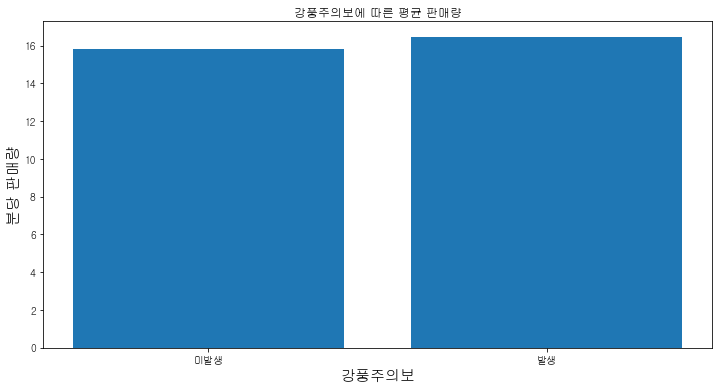

In [25]:
wind_group_df = train_weather['판매량'].groupby(train_weather['storm']).mean()

title = '강풍주의보에 따른 평균 판매량'
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(list(wind_group_df.index), wind_group_df)
ax.set_xlabel('강풍주의보', fontsize = 15)
ax.set_xticks([0, 1])
ax.set_xticklabels(['미발생', '발생'], fontsize = 10)
ax.set_ylabel('분당 판매량', fontsize = 15)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

막대 그래프를 확인했을 때, 강풍주의보 여부에 따른 큰 차이는 없어보인다.    
하지만, T-test를 진행하여 유의미한 차이가 있는지 알아볼 필요는 존재한다.

#### T-Test

- H0 : 호우주의보 발생 여부에 따른 분당 평균 판매량은 차이가 없다.

- H1 : 호우주의보 발생 여부에 따른 분당 평균 판매량은 차이가 있다.

두 집단은 독립이므로 등분산 검정을 실시한 후 독립표본 t-검정을 시행한다.   

In [26]:
# 등분산 검정
# H0 : 두 집단의 분산은 같다.
# H1 : 두 집단은 분산은 다르다.
storm_0 = train_weather.loc[train_weather['storm'] == 0.0] # 강풍주의보 미발령
storm_1 = train_weather.loc[train_weather['storm'] == 1.0] # 강풍주의보 발령

# Levene의 등분산 검정 
lresult = stats.levene(storm_0['판매량'], storm_1['판매량'])
print('LeveneResult(F) : %.3f \np-value : %.3f' % (lresult)) 

LeveneResult(F) : 5.907 
p-value : 0.015


- p-value 0.027로 유의확률 0.05보다 작으므로 귀무가설을 기각한다.
- 즉, 두 집단의 분산은 다르다는 것을 알 수 있다.

In [27]:
# 등분산이 아닌 독립표본 t-검정 실행 
t_result = stats.ttest_ind(storm_0['판매량'], storm_1['판매량'], equal_var=False) 
print('t statistic : %.3f \np-value : %.3f' % (t_result))

t statistic : -2.255 
p-value : 0.024


두 집단 간 평균 판매량에 대한 T-test를 진행한 결과, p-value가 0.024로 유의확률 0.05보다 작으므로 귀무가설을 기각한다.   
즉, 강풍주의보 발생 여부에 따른 분단 평균 판매량은 차이가 있다고 할 수 있다.   
'호우주의보 발생 여부' 변수를 생성한다.

In [28]:
# 20년 강풍 주의보 데이터
storm_20=pd.read_csv('./Weathers/FCT_WRN_2020_06_강풍.csv',encoding='utf-8')
storm_20=storm_20.drop('Unnamed: 1',axis=1)
storm_20=storm_20.loc[storm_20['특보통보'].str.contains(pat='2020')==True].reset_index(drop=True)
storm_20=storm_20.loc[storm_20['특보통보'].str.contains(pat='강풍주의보')==True].reset_index(drop=True)

storm_20['구분']=pd.Series()
storm_20['year']=pd.Series()
storm_20['month']=pd.Series()
storm_20['day']=pd.Series()
storm_20['hour']=pd.Series()
storm_20['minute']=pd.Series()
storm_20['date']=pd.Series()

for i in range(len(storm_20)):
    storm_20.loc[i,'구분']=storm_20.loc[i,'특보통보'][10:12]
    storm_20.loc[i,'year']=storm_20.loc[i,'특보통보'][15:19]
    storm_20.loc[i,'month']=storm_20.loc[i,'특보통보'][21:23]
    storm_20.loc[i,'day']=storm_20.loc[i,'특보통보'][25:27]
    storm_20.loc[i,'hour']=storm_20.loc[i,'특보통보'][29:31]
    storm_20.loc[i,'minute']=storm_20.loc[i,'특보통보'][33:35]
    
storm_20 = storm_20.drop(14).reset_index(drop=True)
storm_20['date']=storm_20['year']+'-'+storm_20['month']+'-'+storm_20['day']+' '+storm_20['hour']+':'+storm_20['minute']
storm_20=storm_20[storm_20['구분']!='변경']
storm_20=storm_20[storm_20['구분']!='연장']
storm_20=storm_20[storm_20['구분']!='대치']

storm_20=storm_20.drop_duplicates()
storm_20=storm_20.reset_index(drop=True)
storm_20['date']=pd.to_datetime(storm_20['date'])
storm_20=storm_20.sort_values(by=['date'])

storm_list = [0]
for i in range(len(storm_20)):
    if i == (len(storm_20)-1):
        storm_list.append(i)
        break
    a = storm_20.loc[i,'구분']
    b = storm_20.loc[i+1,'구분']
    if (a == '해제')&(b=='발표'):
        storm_list.append(i)
        storm_list.append(i+1)
    
storm_20 = storm_20.iloc[storm_list].reset_index(drop=True)
storm_20['date']=pd.to_datetime(storm_20['date'])
storm_20.head(3)

,특보통보,구분,year,month,day,hour,minute,date
0,(1) 강풍주의보 발표 : 2020년 06월 24일 01시 00분,발표,2020,06,24,01,00,2020-06-24 01:00:00
1,(1) 강풍주의보 해제 : 2020년 06월 24일 19시 30분,해제,2020,06,24,19,30,2020-06-24 19:30:00
2,(1) 강풍주의보 발표 : 2020년 06월 29일 10시 00분,발표,2020,06,29,10,00,2020-06-29 10:00:00


In [29]:
# Test 데이터 '강풍 주의보' 변수 생성
test_weather['storm']=0.0 # 미발생

for j in range(len(storm_20)):
    if j%2==0:
        test_weather.loc[(test_weather['방송일시']>storm_20['date'][j]) & (test_weather['방송일시']<storm_20['date'][j+1]),'storm']=1.0

### 폭염주의보

In [30]:
# 2019년 폭염주의보 데이터
hot=pd.read_csv('./Weathers/FCT_WRN_폭염.csv',encoding='cp949')
hot.head(3)

,특보통보,Unnamed: 1
0,발표시각,지역
1,2019-05-15 15:00,전국
2,발효시각,NaN


In [31]:
hot=hot.drop('Unnamed: 1',axis=1)
hot=hot.loc[hot['특보통보'].str.contains(pat='폭염')==True].reset_index(drop=True) # 폭염 데이터 추출
# 경보와 주의보 두개가 존재하지만 폭염주의보만 활용하기로 한다.
hot=hot.loc[hot['특보통보'].str.contains(pat='주의보')==True].reset_index(drop=True) # 폭염주의보 데이터 추출
hot=hot.loc[hot['특보통보'].str.contains(pat='2019')==True].reset_index(drop=True) # 2019년 데이터 추출

hot.head(3)

,특보통보
0,(1) 폭염주의보 발표 : 2019년 05월 15일 15시 00분
1,(1) 폭염주의보 해제 : 2019년 05월 16일 18시 00분
2,(1) 폭염주의보 발표 : 2019년 05월 23일 11시 00분


In [32]:
hot['구분']=pd.Series()
hot['year']=pd.Series()
hot['month']=pd.Series()
hot['day']=pd.Series()
hot['hour']=pd.Series()
hot['minute']=pd.Series()
hot['date']=pd.Series()

# 해제와 발표가 정상적으로 이루어진 경우의 인덱스를 추출하여 변수 생성
for i in tqdm(range(len(hot))):
    hot.loc[i,'구분']=hot.loc[i,'특보통보'][10:12]
    hot.loc[i,'year']=hot.loc[i,'특보통보'][15:19]
    hot.loc[i,'month']=hot.loc[i,'특보통보'][21:23]
    hot.loc[i,'day']=hot.loc[i,'특보통보'][25:27]
    hot.loc[i,'hour']=hot.loc[i,'특보통보'][29:31]
    hot.loc[i,'minute']=hot.loc[i,'특보통보'][33:35]

hot['date']=hot['year']+'-'+hot['month']+'-'+hot['day']+' '+hot['hour']+':'+hot['minute']
hot=hot[hot['구분']!='변경']
hot=hot.drop_duplicates()
hot=hot.reset_index(drop=True)
hot.head(3)

,특보통보,구분,year,month,day,hour,minute,date
0,(1) 폭염주의보 발표 : 2019년 05월 15일 15시 00분,발표,2019,05,15,15,00,2019-05-15 15:00
1,(1) 폭염주의보 해제 : 2019년 05월 16일 18시 00분,해제,2019,05,16,18,00,2019-05-16 18:00
2,(1) 폭염주의보 발표 : 2019년 05월 23일 11시 00분,발표,2019,05,23,11,00,2019-05-23 11:00


In [33]:
hotwave_list = [0] # 발표와 해제가 순서대로 이루어진 인덱스로 이루어진 리스트

for i in tqdm(range(len(hot))):
    if i == (len(hot)-1):
        hotwave_list.append(i)
        break
    a = hot.loc[i,'구분']
    b = hot.loc[i+1,'구분']
    if (a == '해제')&(b=='발표'):
        hotwave_list.append(i)
        hotwave_list.append(i+1)
    
hot = hot.iloc[hotwave_list].reset_index(drop=True)
hot = hot.drop('특보통보',axis=1)
hot['date']=pd.to_datetime(hot['date'])

with open('./pickles/hot.pkl', 'wb') as f: # 완성된 데이터 셋 pickle 형태로 저장
    pickle.dump(hot, f)

hot.head(3)

,구분,year,month,day,hour,minute,date
0,발표,2019,05,15,15,00,2019-05-15 15:00:00
1,해제,2019,05,16,18,00,2019-05-16 18:00:00
2,발표,2019,05,23,11,00,2019-05-23 11:00:00


In [34]:
# Train 데이터에 '폭염 주의보' 변수 생성
train_weather['hot']=0.0

for j in tqdm(range(len(hot))):
    if j%2==0:
        train_weather.loc[(train_weather['방송일시']>hot['date'][j]) & (train_weather['방송일시']<hot['date'][j+1]),'hot']=1.0
        
train_weather.head(3)    

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,date,hour,weekday,month,day,rain,temp,storm,hot
0,2019-01-01 06:00:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,3.0,2019-01-01,06,2,01,01,0.0,-2.1,0.0,0.0
1,2019-01-01 06:00:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,5.0,2019-01-01,06,2,01,01,0.0,-2.1,0.0,0.0
2,2019-01-01 06:20:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,4.0,2019-01-01,06,2,01,01,0.0,-2.1,1.0,0.0


#### 막대 그래프를 통한 변수의 유의성 시각화

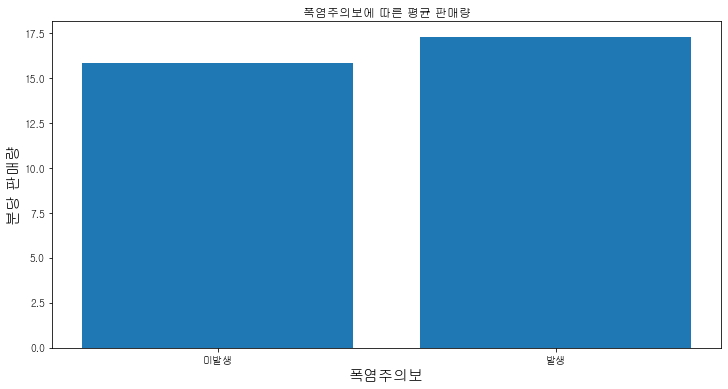

In [35]:
hot_group_df = train_weather['판매량'].groupby(train_weather['hot']).mean()

title = '폭염주의보에 따른 평균 판매량'
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(list(hot_group_df.index), hot_group_df)
ax.set_xlabel('폭염주의보', fontsize = 15)
ax.set_xticks([0, 1])
ax.set_xticklabels(['미발생', '발생'], fontsize = 10)
ax.set_ylabel('분당 판매량', fontsize = 15)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

막대 그래프를 확인했을 때, 강풍주의보 여부에 따른 큰 차이는 없어보인다.    
하지만, T-test를 진행하여 유의미한 차이가 있는지 알아볼 필요는 존재한다.

#### T-Test

- H0 : 폭염주의보 발생 여부에 따른 분당 평균 판매량은 차이가 없다.

- H1 : 폭염주의보 발생 여부에 따른 분당 평균 판매량은 차이가 있다.

두 집단은 독립이므로 등분산 검정을 실시한 후 독립표본 t-검정을 시행한다.   

In [36]:
# 등분산 검정
# H0 : 두 집단의 분산은 같다.
# H1 : 두 집단은 분산은 다르다.
hot_0 = train_weather.loc[train_weather['hot'] == 0.0] # 폭염주의보 미발령
hot_1 = train_weather.loc[train_weather['hot'] == 1.0] # 폭염주의보 발령

# Levene의 등분산 검정 
lresult = stats.levene(hot_0['판매량'], hot_1['판매량'])
print('LeveneResult(F) : %.3f \np-value : %.3f' % (lresult)) 

LeveneResult(F) : 15.271 
p-value : 0.000


- p-value 0.000로 유의확률 0.05보다 작으므로 귀무가설을 기각한다.
- 즉, 두 집단의 분산은 다르다는 것을 알 수 있다.

In [37]:
# 등분산이 아닌 독립표본 t-검정 실행 
t_result = stats.ttest_ind(hot_0['판매량'], hot_1['판매량'], equal_var=False) 
print('t statistic : %.3f \np-value : %.3f' % (t_result))

t statistic : -3.981 
p-value : 0.000


두 집단 간 평균 판매량에 대한 T-test를 진행한 결과, p-value가 0.000로 유의확률 0.05보다 작으므로 귀무가설을 기각한다.   
즉, 폭염주의보 발생 여부에 따른 분단 평균 판매량은 차이가 있다고 할 수 있다.   
'폭염주의보 발생 여부' 변수를 생성한다.

In [38]:
# 2020년 폭염주의보 자료
hot_20=pd.read_csv('./Weathers/FCT_WRN_2020_06_폭염.csv',encoding='utf-8')
hot_20=hot_20.drop('Unnamed: 1',axis=1)

hot_20=hot_20.loc[hot_20['특보통보'].str.contains(pat='폭염')==True].reset_index(drop=True)
hot_20=hot_20.loc[hot_20['특보통보'].str.contains(pat='주의보')==True].reset_index(drop=True)
hot_20=hot_20.loc[hot_20['특보통보'].str.contains(pat='2020')==True].reset_index(drop=True)

hot_20['구분']=pd.Series()
hot_20['year']=pd.Series()
hot_20['month']=pd.Series()
hot_20['day']=pd.Series()
hot_20['hour']=pd.Series()
hot_20['minute']=pd.Series()
hot_20['date']=pd.Series()

for i in tqdm(range(len(hot_20))):
    hot_20.loc[i,'구분']=hot_20.loc[i,'특보통보'][10:12]
    hot_20.loc[i,'year']=hot_20.loc[i,'특보통보'][15:19]
    hot_20.loc[i,'month']=hot_20.loc[i,'특보통보'][21:23]
    hot_20.loc[i,'day']=hot_20.loc[i,'특보통보'][25:27]
    hot_20.loc[i,'hour']=hot_20.loc[i,'특보통보'][29:31]
    hot_20.loc[i,'minute']=hot_20.loc[i,'특보통보'][33:35]

hot_20['date']=hot_20['year']+'-'+hot_20['month']+'-'+hot_20['day']+' '+hot_20['hour']+':'+hot_20['minute']
hot_20=hot_20[hot_20['구분']!='변경']
hot_20=hot_20.drop_duplicates()
hot_20=hot_20.reset_index(drop=True)
hot_wave_list = [0] # 발표와 해제가 순서대로 이루어진 인덱스로 이루어진 리스트

for i in tqdm(range(len(hot_20))):
    if i == (len(hot_20)-1):
        hot_wave_list.append(i)
        break
    a = hot_20.loc[i,'구분']
    b = hot_20.loc[i+1,'구분']
    if (a == '해제')&(b=='발표'):
        hot_wave_list.append(i)
        hot_wave_list.append(i+1)
        
hot_20 = hot_20.iloc[hot_wave_list].reset_index(drop=True)
hot_20=hot_20.drop('특보통보',axis=1)
hot_20['date']=pd.to_datetime(hot_20['date'])

with open('./pickles/hot_20.pkl', 'wb') as f: # 완성된 데이터 셋 pickle 형태로 저장
    pickle.dump(hot_20, f)

hot_20.head(3)

,구분,year,month,day,hour,minute,date
0,발표,2020,06,04,11,00,2020-06-04 11:00:00
1,해제,2020,06,05,17,00,2020-06-05 17:00:00
2,발표,2020,06,08,11,00,2020-06-08 11:00:00


In [39]:
# Test 데이터에 '폭염주의보' 변수 생성
test_weather['hot']=0.0

for j in range(len(hot_20)):
    if j%2==0:
        test_weather.loc[(test_weather['방송일시']>hot_20['date'][j]) & (test_weather['방송일시']<hot_20['date'][j+1]),'hot']=1.0
        
test_weather.head(3) # 폭염주의보 변수 생성 완료

,index,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,date,hour,weekday,month,day,rain,temp,storm,hot
0,1,2020-06-01 06:20:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01,06,1,06,01,0.0,20.8,0.0,0.0
1,2,2020-06-01 06:40:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01,06,1,06,01,0.0,20.8,0.0,0.0
2,3,2020-06-01 07:00:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01,07,1,06,01,0.0,20.8,0.0,0.0


### 해일

In [40]:
# 2019년 해일 데이터
tsunami = pd.read_csv('./Weathers/FCT_WRN_2019_폭풍해일_raw.csv',encoding='cp949')
tsunami.head(3) # 자료의 수가 매우 작은 것을 확인

,특보통보,Unnamed: 1
0,발표시각,지역
1,2019-10-03 10:00,전국
2,발효시각,NaN


해일의 경우에는 2019년에 1번 발표한 적이 있다. 데이터의 수가 매우 작으므로 사용하지 않는다.

### 미세먼지

In [41]:
# 2019년 미세먼지 데이터
PM10 = pd.read_csv('./Weathers/OBS_부유분진_TIM_20200926071119(2019_전국 미세먼지).csv',encoding='cp949')
PM10.head(3)

,지점,지점명,일시,1시간평균 미세먼지농도(㎍/㎥)
0,90,속초,2019-01-01 01:00,16
1,90,속초,2019-01-01 02:00,26
2,90,속초,2019-01-01 03:00,16


In [42]:
PM10.columns = ['one','two','date','mise']
PM10 = PM10[['date','mise']]
PM10 = PM10.groupby('date').mean().reset_index()
PM10['수준'] = pd.Series()
for i in tqdm(range(len(PM10))): # 미세먼지 농도에 따라 변수의 범주화 진행
    if PM10.loc[i,'mise']<=30:
        PM10.loc[i,'수준']='좋음'
    elif PM10.loc[i,'mise']<=80:
        PM10.loc[i,'수준']='보통'
    else:
        PM10.loc[i,'수준']='나쁨'
        
PM10['date']=pd.to_datetime(PM10['date'])
PM10['date']=PM10['date'].apply(lambda x:x.strftime('%Y-%m-%d %H'))

with open('./pickles/PM10.pkl', 'wb') as f: # 완성된 데이터 셋 pickle 형태로 저장
    pickle.dump(PM10, f)

PM10.head(3)

,date,mise,수준
0,2019-01-01 01,29.807692,좋음
1,2019-01-01 02,29.758621,좋음
2,2019-01-01 03,29.137931,좋음


In [43]:
# Train 데이터에 미세먼지 변수 생성

train_weather['kk']=train_weather['방송일시'].apply(lambda x:x.strftime('%Y-%m-%d %H')) # datetime 형태 맞추기 위해 새로운 컬럼 생성
train_weather['PM10']=0.0   #매우나쁨

for i in tqdm(range(len(PM10))):
    if PM10['수준'][i]=='나쁨':
        train_weather.loc[train_weather['kk']==PM10['date'][i],'PM10']=1.0  #나쁨
    elif PM10['수준'][i]=='보통':
        train_weather.loc[train_weather['kk']==PM10['date'][i],'PM10']=2.0  #보통
    elif PM10['수준'][i]=='좋음':
        train_weather.loc[train_weather['kk']==PM10['date'][i],'PM10']=3.0  #좋음

train_weather=train_weather.drop('kk',axis=1) # 임의로 만든 변수 삭제
train_weather.head(3)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,date,hour,weekday,month,day,rain,temp,storm,hot,PM10
0,2019-01-01 06:00:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,3.0,2019-01-01,06,2,01,01,0.0,-2.1,0.0,0.0,3.0
1,2019-01-01 06:00:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,5.0,2019-01-01,06,2,01,01,0.0,-2.1,0.0,0.0,3.0
2,2019-01-01 06:20:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,4.0,2019-01-01,06,2,01,01,0.0,-2.1,1.0,0.0,3.0


#### 막대 그래프를 통한 변수의 유의성 시각화

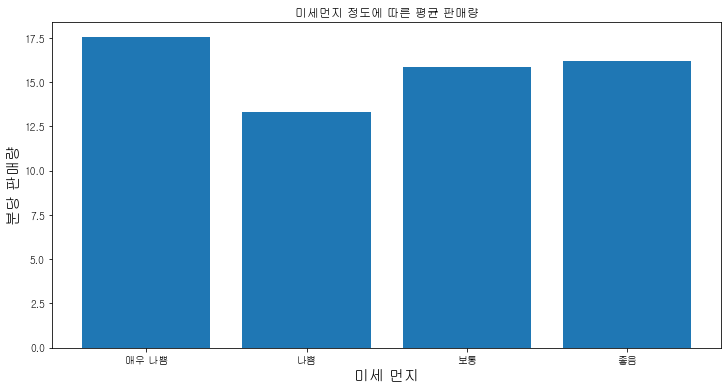

In [44]:
PM10_group_df = train_weather['판매량'].groupby(train_weather['PM10']).mean()

title = '미세먼지 정도에 따른 평균 판매량'
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(list(PM10_group_df.index), PM10_group_df)
ax.set_xlabel('미세 먼지', fontsize = 15)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['매우 나쁨', '나쁨', '보통', '좋음'], fontsize = 10)
ax.set_ylabel('분당 판매량', fontsize = 15)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

In [45]:
PM10_20 = pd.read_csv('./Weathers/OBS_부유분진_TIM_202006(전국 미세먼지).csv',encoding='cp949')
PM10_20.columns = ['one','two','date','mise']
PM10_20 = PM10_20[['date','mise']]
PM10_20 = PM10_20.groupby('date').mean().reset_index()
PM10_20['수준'] = pd.Series()
for i in range(len(PM10_20)):
    if PM10_20.loc[i,'mise']<=30:
        PM10_20.loc[i,'수준']='좋음'
    elif PM10_20.loc[i,'mise']<=80:
        PM10_20.loc[i,'수준']='보통'
    else:
        PM10_20.loc[i,'수준']='나쁨'
        
PM10_20['date']=pd.to_datetime(PM10_20['date'])
test_weather['kk']=test_weather['방송일시'].apply(lambda x:x.strftime('%Y-%m-%d %H'))  
PM10_20['date']=PM10_20['date'].apply(lambda x:x.strftime('%Y-%m-%d %H'))
test_weather['PM10']=0.0   #매우나쁨

for i in tqdm(range(len(PM10_20))):
    if PM10_20['수준'][i]=='나쁨':
        test_weather.loc[test_weather['kk']==PM10_20['date'][i],'PM10']=1.0  #나쁨
    elif PM10_20['수준'][i]=='보통':
        test_weather.loc[test_weather['kk']==PM10_20['date'][i],'PM10']=2.0  #보통
    elif PM10_20['수준'][i]=='좋음':
        test_weather.loc[test_weather['kk']==PM10_20['date'][i],'PM10']=3.0  #좋음

test_weather=test_weather.drop('kk',axis=1)

미세먼지가 매우 나쁨일 경우, 분당 판매량이 가장 높은 것을 볼 수 있다.   
- 이는 외출을 자제하게 됨으로써, 홈쇼핑을 보는 사람들이 많아질 것이라는 추측을 할 수 있다.

In [46]:
with open('./pickles/train_weather.pkl', 'wb') as f: # 완성된 데이터 셋 pickle 형태로 저장
    pickle.dump(train_weather, f)

with open('./pickles/test_weather.pkl', 'wb') as f: # 완성된 데이터 셋 pickle 형태로 저장
    pickle.dump(test_weather, f)

print(train_weather.head(3))
print('-'*50)
print(test_weather.head(3))

                  방송일시 노출(분)    마더코드    상품코드            상품명 상품군   판매단가  \
0  2019-01-01 06:00:00    20  100346  201072  테이트 남성 셀린니트3종  의류  39900   
1  2019-01-01 06:00:00    20  100346  201079  테이트 여성 셀린니트3종  의류  39900   
2  2019-01-01 06:20:00    20  100346  201072  테이트 남성 셀린니트3종  의류  39900   

       취급액  판매량        date hour weekday month day  rain  temp  storm  hot  \
0  2099000  3.0  2019-01-01   06       2    01  01   0.0  -2.1    0.0  0.0   
1  4371000  5.0  2019-01-01   06       2    01  01   0.0  -2.1    0.0  0.0   
2  3262000  4.0  2019-01-01   06       2    01  01   0.0  -2.1    1.0  0.0   

   PM10  
0   3.0  
1   3.0  
2   3.0  
--------------------------------------------------
   index                 방송일시 노출(분)    마더코드    상품코드              상품명 상품군  \
0      1  2020-06-01 06:20:00    20  100650  201971  잭필드 남성  반팔셔츠 4종  의류   
1      2  2020-06-01 06:40:00    20  100650  201971  잭필드 남성  반팔셔츠 4종  의류   
2      3  2020-06-01 07:00:00    20  100650  201971  잭필드 남성  반팔셔츠 4종  의